## Libraries - Parameters

In [5]:
# Basic libraries
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
# Visualization library
import matplotlib.pyplot as plt
# User's library
from utils.PerformanceProfiles import *
from utils.non_parametric_tests import *


# ACIC
Problem = "Synthetic"

# Get files
PATH = './Results/'
Files = [f for f in listdir(PATH) if isfile(join(PATH, f))]

## Load data

In [6]:
Methods = []
for i, file in enumerate( Files ):
    # Select only csv files
    #
    if ('.csv' not in file): continue
        
    # Select on results from selected Problem
    #
    if ( Problem not in file ): continue
        
        
    # Get method name
    #
    Method = file.split('.csv')[0].split('_')[1]
    
    Methods += [ Method ]

# Sort list with methods
Methods.sort()

for i, x in enumerate( Methods ):
    print('%2i: %s' % (i+1, x))

 1: C-Forest
 2: C-XGBoost
 3: DragonNet
 4: LR1
 5: R-Forest
 6: kNN-DragonNet-euclidean-k=11


#### Select Methods/Solvers 

In [9]:
SelectedMethods = [
                    "R-Forest",
                    "C-Forest",
                    "DragonNet",
                    "kNN-DragonNet-euclidean-k=11",
                    "C-XGBoost",                    
]

#### Merge files

In [10]:
Error_ATE  = pd.DataFrame([])
Error_PEHE = pd.DataFrame([])

for i, file in enumerate( Files ):
    # Select only csv files
    if ('.csv' not in file): continue
        
    # Select on results from IHDP
    if (Problem != file.split("_")[0]): continue
    
    
    # Select methods
    Method = file.split('.csv')[0].split('_')[1]
    if (Method not in SelectedMethods): continue
    
    # Open DataFrame
    df = pd.read_csv(PATH + file)
    
    if (Error_ATE.shape[0] == 0):
        Error_ATE['Problem'], Error_PEHE['Problem']  = df.Problem, df.Problem

    Error_ATE[Method], Error_PEHE[Method]  = df['Error_ATE'], df['Error_PEHE']

    

# Set index
Error_ATE.set_index('Problem', inplace = True)
Error_PEHE.set_index('Problem', inplace = True)

# Remove NaN rows if any
Error_ATE.dropna(inplace=True)
Error_PEHE.dropna(inplace=True)

Error_ATE, Error_PEHE = Error_ATE[SelectedMethods], Error_PEHE[SelectedMethods]

print('[INFO] nProblem: ', Error_ATE.shape[0])

[INFO] nProblem:  100


In [11]:
if Problem == "ACIC":
       L = ['ACIC 0', 'ACIC 1', 'ACIC 2', 'ACIC 5', 'ACIC 9', 'ACIC 13', 'ACIC 14',
              'ACIC 15', 'ACIC 17', 'ACIC 18', 'ACIC 22', 'ACIC 24', 'ACIC 25',
              'ACIC 26', 'ACIC 27']

       Error_ATE = Error_ATE[ Error_PEHE.index.isin(L) ]
       Error_PEHE = Error_PEHE[ Error_PEHE.index.isin(L) ]

## Performance profiles

### Error ATE

c:\Users\ioann\Repositories\Project under development\C-XGBoost\utils\PerformanceProfiles.py:103: RuntimeWarning: divide by zero encountered in true_divide
  col = data[:, alt] / minvals  # performance ratio
c:\Users\ioann\Repositories\Project under development\C-XGBoost\utils\PerformanceProfiles.py:103: RuntimeWarning: invalid value encountered in true_divide
  col = data[:, alt] / minvals  # performance ratio


Method: \textsc{R-Forest} - 0.28
Method: \textsc{C-Forest} - 0.01
Method: \textsc{Dragonnet} - 0.02
Method: $k$\textsc{NN-Dragonnet} - 0.00
Method: \textsc{C-XGBoost} - 0.66


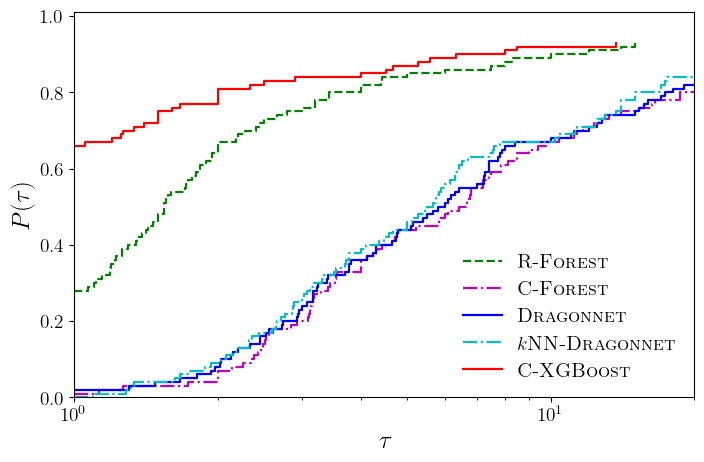

In [28]:
perfprof(Error_ATE.values, 
         linespecs = ['g--', 'm-.', 'b-', 'c-.', 'r-'], 
         digit = 3,
         legendnames = ["\\textsc{R-Forest}", "\\textsc{C-Forest}", "\\textsc{Dragonnet}", "$k$\\textsc{NN-Dragonnet}", "\\textsc{C-XGBoost}", ],
        #  legendnames = Error_ATE.columns,
         thmax = 20, figsize = (8, 5) )

plt.xscale('log')

plt.savefig( 'images/{}_Error_ATE.png'.format(Problem), dpi = 300 )

### Error PEHE

[INFO] nProblem:  100
Method: \textsc{R-Forest} - 0.00
Method: \textsc{C-Forest} - 0.06
Method: \textsc{Dragonnet} - 0.28
Method: $k$\textsc{NN-Dragonnet} - 0.11
Method: \textsc{C-XGBoost} - 0.58


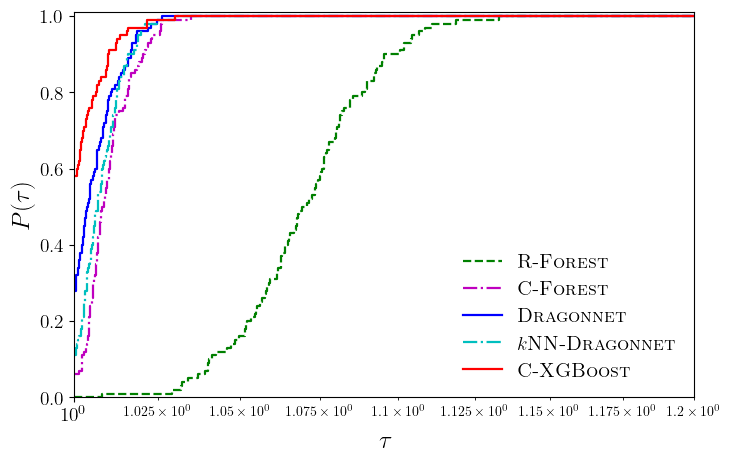

In [27]:
print('[INFO] nProblem: ', Error_ATE.shape[0])

perfprof(Error_PEHE,
         linespecs = ['g--', 'm-.', 'b-', 'c-.', 'r-'], 
         digit = 4,
         legendnames = ["\\textsc{R-Forest}", "\\textsc{C-Forest}", "\\textsc{Dragonnet}", "$k$\\textsc{NN-Dragonnet}", "\\textsc{C-XGBoost}", ],
        #  legendnames = Error_ATE.columns,
         thmax = 1.2, figsize = (8, 5) )

plt.xscale('log')

plt.savefig( 'images/{}_Error_PEHE.png'.format(Problem), dpi = 300 )

## Statistical analysis

### ATE

#### Friedman Aligned Ranking (FAR)

In [ ]:
T, p_value, rankings_avg, rankings_cmp = friedman_aligned_ranks_test( Error_ATE )


# Summary
#
print('\n')
print('[INFO] H0: {All methods exhibited similar results with no statistical differences}')
print('[INFO] FAR: %.3f (p-value: %.5f)' % (T, p_value))
if (p_value < 0.05):
    print('\t> H0 is rejected')
else:
    print('\t> H0 is failed to be rejected')


Ranking            = pd.DataFrame( [] )
Ranking['Methods'] = Error_ATE.columns
Ranking['FAR']     = rankings_avg

Ranking = Ranking.sort_values(by           = 'FAR', 
                              ignore_index = True)
Ranking

#### Finner post-hoc test

**Multiple comparisons ($1 \times N$)**

In [ ]:
# Create dictionary with rankings
#
d = {}
for i, feature in enumerate( Error_ATE.columns ):
    d[ feature ] = rankings_cmp[i] 
    
comparisons, z_values, p_values, adj_p_values = finner_test( d )

Finner = pd.DataFrame( [] )
Finner['Comparisons']     = comparisons
Finner['APV']             = adj_p_values
Finner['Null hypothesis'] = Finner['APV'].apply(lambda x: 'Rejected' if x < 0.05 else 'Failed to reject')

Finner = Finner.sort_values(by = 'APV', ascending = False, ignore_index = True)
Finner

### PEHE

#### Friedman Aligned Ranking (FAR)

In [ ]:
T, p_value, rankings_avg, rankings_cmp = friedman_aligned_ranks_test( Error_PEHE )


# Summary
#
print('\n')
print('[INFO] H0: {All methods exhibited similar results with no statistical differences}')
print('[INFO] FAR: %.3f (p-value: %.5f)' % (T, p_value))
if (p_value < 0.05):
    print('\t> H0 is rejected')
else:
    print('\t> H0 is failed to be rejected')


Ranking            = pd.DataFrame( [] )
Ranking['Methods'] = Error_PEHE.columns
Ranking['FAR']     = rankings_avg

Ranking = Ranking.sort_values(by           = 'FAR', 
                              ignore_index = True)
Ranking

#### Finner post-hoc test

**Multiple comparisons ($1 \times N$)**

In [ ]:
# Create dictionary with rankings
#
d = {}
for i, feature in enumerate( Error_PEHE.columns ):
    d[ feature ] = rankings_cmp[i] 
    
comparisons, z_values, p_values, adj_p_values = finner_test( d )

Finner = pd.DataFrame( [] )
Finner['Comparisons']     = comparisons
Finner['APV']             = adj_p_values
Finner['Null hypothesis'] = Finner['APV'].apply(lambda x: 'Rejected' if x < 0.05 else 'Failed to reject')

Finner = Finner.sort_values(by = 'APV', ascending = False, ignore_index = True)
Finner